# Проект: Классификация

*Бизнес-задача*: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

*Техническая задача*: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

Основные цели:
1. Исследовать данные;
2. Выявить характерные черты для потенциальных клиентов, чтобы чётко очертить ЦА и увеличить прибыль банка;
3. Использовать разные инструменты для повышения качества прогноза.

In [1]:
#import standard libraries
import pandas as pd, numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#warnings
import warnings
warnings.filterwarnings('ignore')

#encoding features
from sklearn.preprocessing import LabelEncoder

#libraries for model learning
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn import model_selection
from sklearn import feature_selection

#libraries for hyperparameters
import optuna
from optuna import Trial, study, samplers

Данные о клиентах банка:

        age (возраст);
        job (сфера занятости);
        marital (семейное положение);
        education (уровень образования);
        default (имеется ли просроченный кредит);
        housing (имеется ли кредит на жильё);
        loan (имеется ли кредит на личные нужды);
        balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

        contact (тип контакта с клиентом);
        month (месяц, в котором был последний контакт);
        day (день, в который был последний контакт);
        duration (продолжительность контакта в секундах).

Прочие признаки:

        campaign (количество контактов с этим клиентом в течение текущей кампании);
        pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
        previous (количество контактов до текущей кампании)
        poutcome (результат прошлой маркетинговой кампании).

И, разумеется, целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке.

## **Часть 1:** Знакомство с данными, обработка пропусков и выбросов

##### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


In [4]:
#total number of records / features
df.shape

(11162, 17)

In [5]:
#show the basic information about the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Исследуйте данные на предмет пропусков. \
Где есть пропущенные значения? Сколько их?

In [6]:
#check that there are no null values in the data set
df.isnull().sum()[df.isnull().sum() > 0]

balance    25
dtype: int64

##### Задание 2

Есть ли в признаке job пропущенные значения? \
Возможно, они обозначены каким-то специальным словом?

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [8]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

##### Задание 3

Преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float).

In [9]:
#check the distribution / categories in the feature
df['balance'].value_counts()

balance
0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: count, Length: 3802, dtype: int64

In [10]:
#convert to string
df['balance'] = df['balance'].astype('string')

#replace the elements: ['$', ',', ' '] with a space
df['balance'] = df['balance'].str.replace('$', '').str.replace(',', '.').str.replace(' ', '')

#trim the beginning of the string
df.balance = df.balance.replace('^\s+', '', regex=True)

#trim the end of the string
df.balance = df.balance.replace('\s+$', '', regex=True)

#convert to float
df['balance'] = df['balance'].astype(float)

In [11]:
#check the distribution / categories in the feature
df['balance'].value_counts()

balance
 0.0       774
 1.0        39
 3.0        34
 2.0        34
 4.0        29
          ... 
 1641.0      1
 5517.0      1
 8332.0      1
 4859.0      1
-134.0       1
Name: count, Length: 3802, dtype: int64

In [12]:
#find the mean value
df['balance'].mean().round(3)

1529.129

##### Задание 4

Обработайте пропуски в признаки balance, заменив их на медианные значения по данному признаку.

In [13]:
#find the median value for the feature
df['balance'].median()

550.0

In [14]:
#set blank balance to the median value
df['balance'] = df['balance'].fillna(df['balance'].median())

In [15]:
#check the distribution / categories in the feature
df['balance'].value_counts()

balance
 0.0       774
 1.0        39
 2.0        34
 3.0        34
 550.0      31
          ... 
 1641.0      1
 5517.0      1
 8332.0      1
 4859.0      1
-134.0       1
Name: count, Length: 3802, dtype: int64

In [16]:
#find the mean value
df['balance'].mean().round(3)

1526.936

##### Задание 5

Обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения.

In [17]:
#find the columns with a specific data type
df.dtypes[df.dtypes == 'object']

job          object
marital      object
education    object
default      object
housing      object
loan         object
contact      object
month        object
poutcome     object
deposit      object
dtype: object

(a) feature: job

In [18]:
#check the distribution / categories in the feature
print(df['job'].value_counts())
print()
print(df['job'].mode())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

0    management
Name: job, dtype: object


In [19]:
#convert to string
df['job'] = df['job'].astype('string')

#set null job to the mode value
df['job'] = df['job'].apply(lambda x: 'management' if x == 'unknown' else x)

In [20]:
#check the distribution / categories in the feature
df['job'].value_counts()

job
management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64

(b) feature: education

In [21]:
#check the distribution / categories in the feature
print(df['education'].value_counts())
print()
print(df['education'].mode())

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

0    secondary
Name: education, dtype: object


In [22]:
#convert to string
df['education'] = df['education'].astype('string')

#set null job to the mode value
df['education'] = df['education'].apply(lambda x: 'secondary' if x == 'unknown' else x)

In [23]:
#check the distribution / categories in the feature
df['education'].value_counts()

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т.е. для тех, у кого одновременно самая популярная работа и самое популярное образование).

In [24]:
#find the records for clients with most frequent job / education
most_popular = df[(df['job'] == 'management') & (df['education'] == 'secondary')]

#find the average balance for these clients
most_popular['balance'].mean().round(3)

1598.883

##### Задание 6

Удалите все выбросы для признака balance.

In [25]:
#show basic statistics for the feature
df['balance'].describe().round(2)

count    11162.00
mean      1526.94
std       3224.83
min      -6847.00
25%        123.00
50%        550.00
75%       1699.00
max      81204.00
Name: balance, dtype: float64

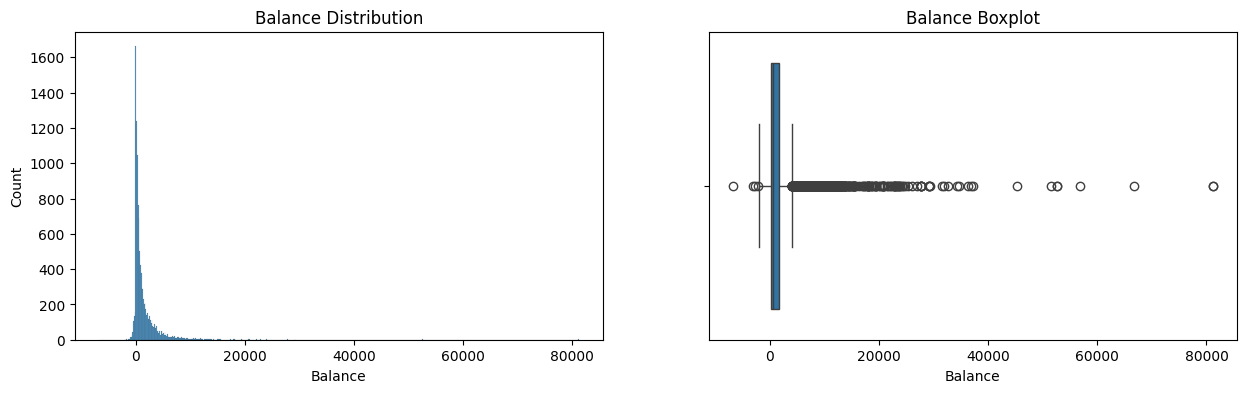

In [26]:
#visualize the distribution of feature 'balance'
#set the canvas
fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(15, 4))

#create a histogram
histplot = sns.histplot(data=df,
                        x='balance',
                        ax=axes[0]);
histplot.set_xlabel('Balance')
histplot.set_title('Balance Distribution');

#create a boxplot
boxplot = sns.boxplot(data=df,
                      x='balance',
                      ax=axes[1]);
boxplot.set_xlabel('Balance')
boxplot.set_title('Balance Boxplot');

In [27]:
#create a function to find the outliers
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

In [28]:
outliers, df, lower_bound, upper_bound = outliers_iqr_mod(df, 'balance')
print(f"Number of outliers found using the Tukey's Method: {outliers.shape[0]}")
print(f'Lower and Upper Bounds: ({round(lower_bound)}, {round(upper_bound)})')

Number of outliers found using the Tukey's Method: 1057
Lower and Upper Bounds: (-2241, 4063)


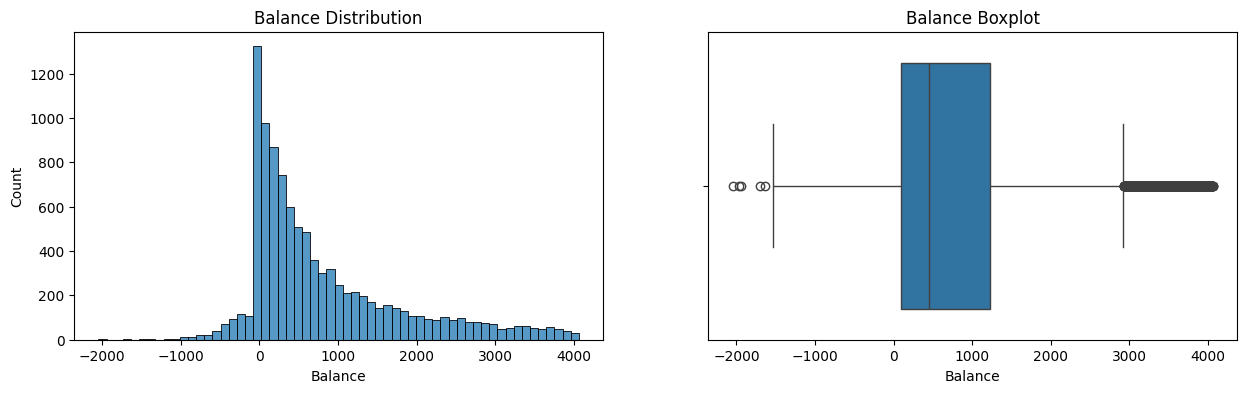

In [29]:
#visualize the distribution of feature 'balance' after deleting the outliers
#set the canvas
fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(15, 4))

#create a histogram
histplot = sns.histplot(data=df,
                        x='balance',
                        ax=axes[0]);
histplot.set_xlabel('Balance')
histplot.set_title('Balance Distribution');

#create a boxplot
boxplot = sns.boxplot(data=df,
                      x='balance',
                      ax=axes[1]);
boxplot.set_xlabel('Balance')
boxplot.set_title('Balance Boxplot');

##### Задание 7

Сколько объектов осталось после удаления всех выбросов?

In [30]:
print(f'Resulting number of records after deleting the outliers: {df.shape[0]}')

Resulting number of records after deleting the outliers: 10105


## **Часть 2**: Разведывательный Анализ

В данной части необходимо:

- исследовать данные;
- найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления целевого признака - депозита;
- дополнить анализ визуализациями, иллюстрирующими исследование

##### Задание 1

Изучите соотношение классов в данных на предмет несбалансированности, проиллюстрируйте результат.

In [31]:
#check the distribution / categories in the predictive feature
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

In [32]:
#check the %-distribution / categories in the predictive feature
round(df['deposit'].value_counts(normalize=True) * 100, 2)

deposit
no     53.68
yes    46.32
Name: proportion, dtype: float64

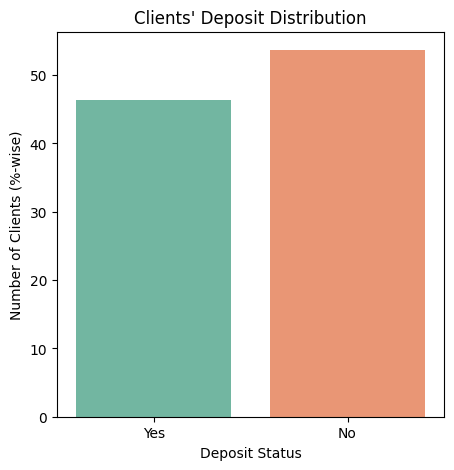

In [33]:
#check the predictive feature (%-wise)
plt.figure(figsize=(5, 5))
ax = sns.countplot(data=df,
                   x='deposit',
                   stat='percent',
                   palette='Set2');

ax.set(
    title="Clients' Deposit Distribution",
    xlabel='Deposit Status', 
    ylabel='Number of Clients (%-wise)',
    xticklabels=['Yes', 'No']
);

##### Задания 2 и 3

Описательные статистики для количественных переменных:

- Рассчитать и продумать подробную интерпретацию;
- Описать данные, которые есть, увидеть первые зависимости;
- Рассмотреть минимальные и максимальные значения;
- Посмотреть на меры разброса и оценить, насколько данные вариативны;
- Сравнить меры центральной тенденции, сделать выводы о том, есть ли аномальные значения с меньшей или большей стороны.

Рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат.

In [34]:
#find the columns with a specific data type
numeric_features = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')]

#show basic statistics for numeric features
df[numeric_features.index].describe().round()

,age,balance,day,duration,campaign,pdays,previous
count,10105.0,10105.0,10105.0,10105.0,10105.0,10105.0,10105.0
mean,41.0,808.0,16.0,369.0,3.0,51.0,1.0
std,12.0,994.0,8.0,347.0,3.0,110.0,2.0
min,18.0,-2049.0,1.0,2.0,1.0,-1.0,0.0
25%,32.0,95.0,8.0,137.0,1.0,-1.0,0.0
50%,38.0,445.0,15.0,252.0,2.0,-1.0,0.0
75%,48.0,1227.0,22.0,490.0,3.0,2.0,1.0
max,95.0,4063.0,31.0,3881.0,43.0,854.0,58.0


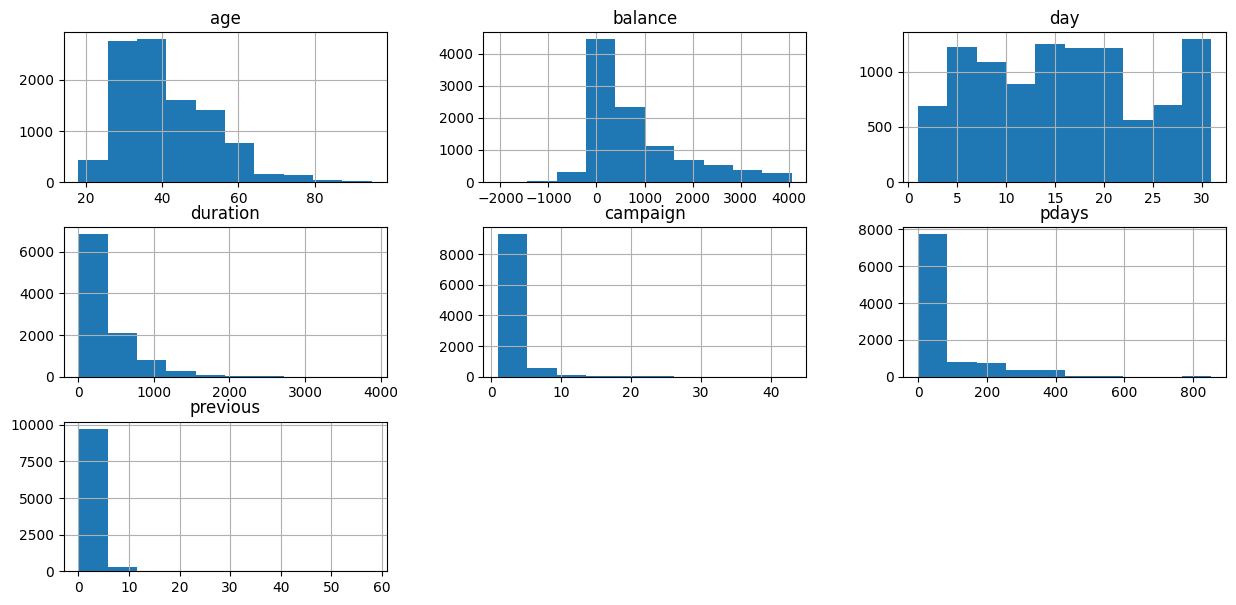

In [35]:
#creat a new dataframe with numeric features only to increase the performance
df_numeric = pd.concat([df.age, df.balance, df.day, df.duration, df.campaign, df.pdays, df.previous],
                       axis = 1)

#create histograms of numerical features only  
df_numeric.hist(figsize = (15, 7));

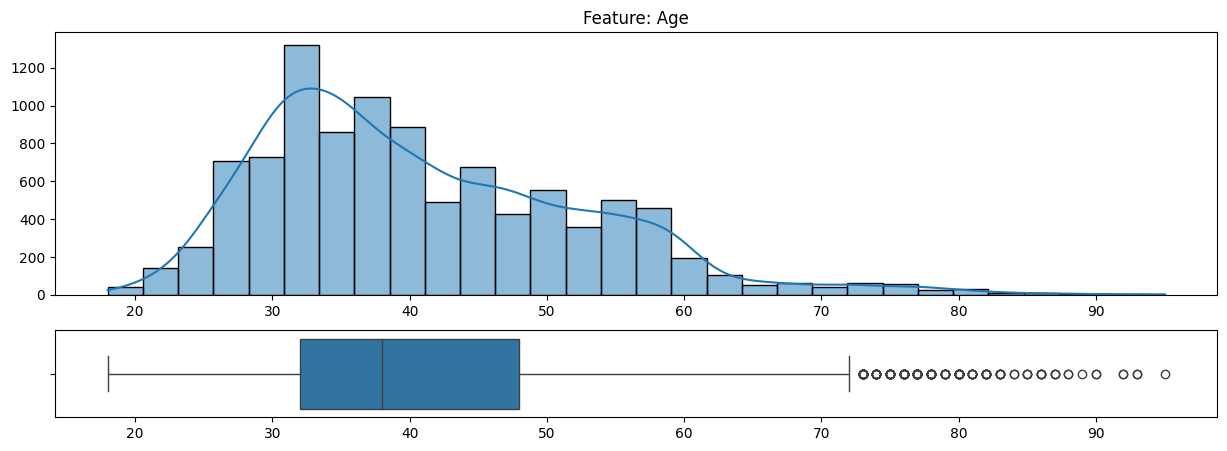

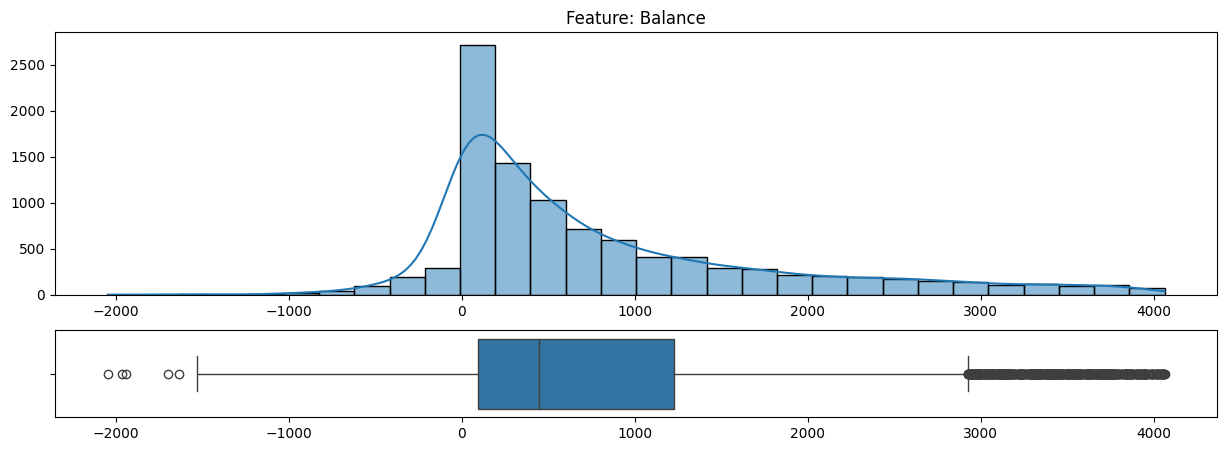

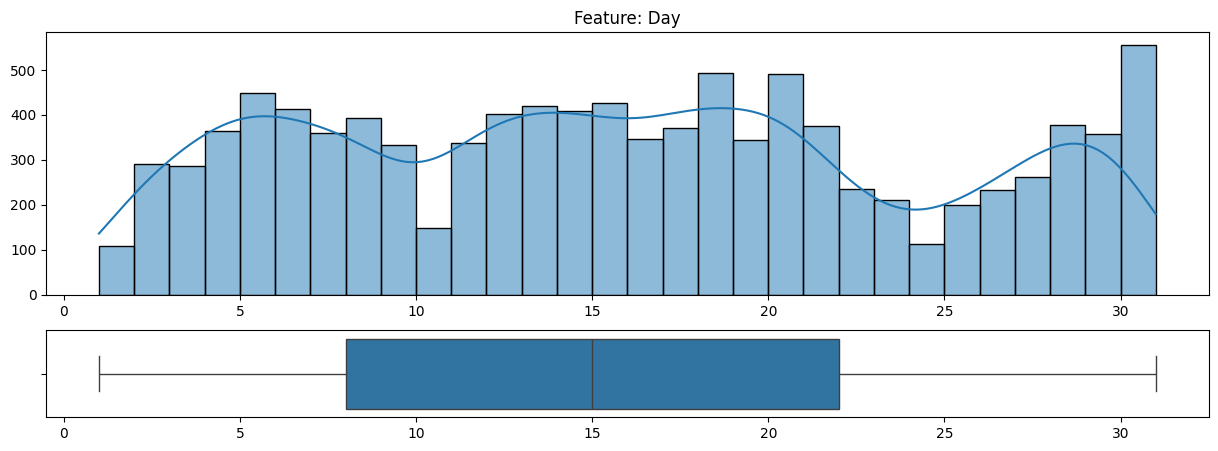

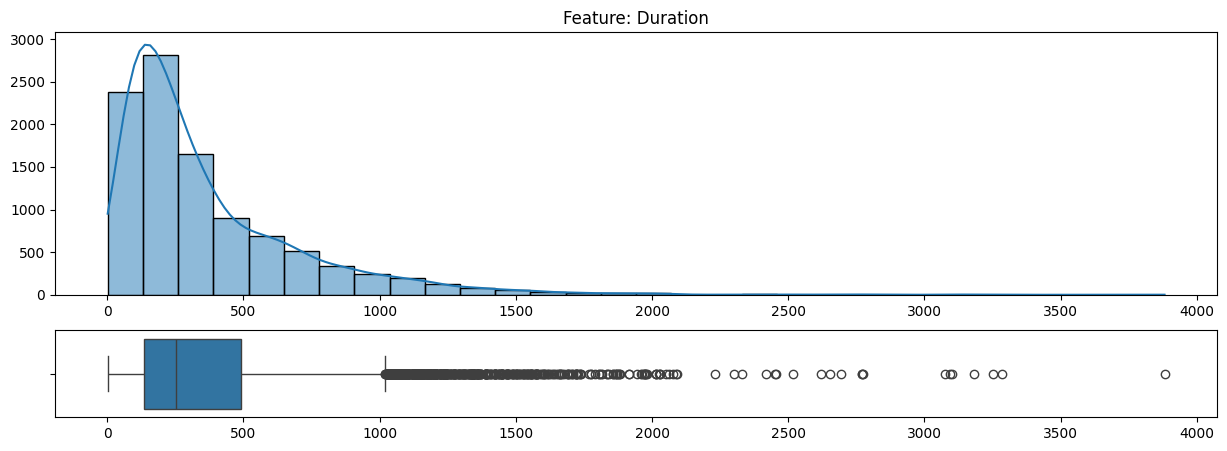

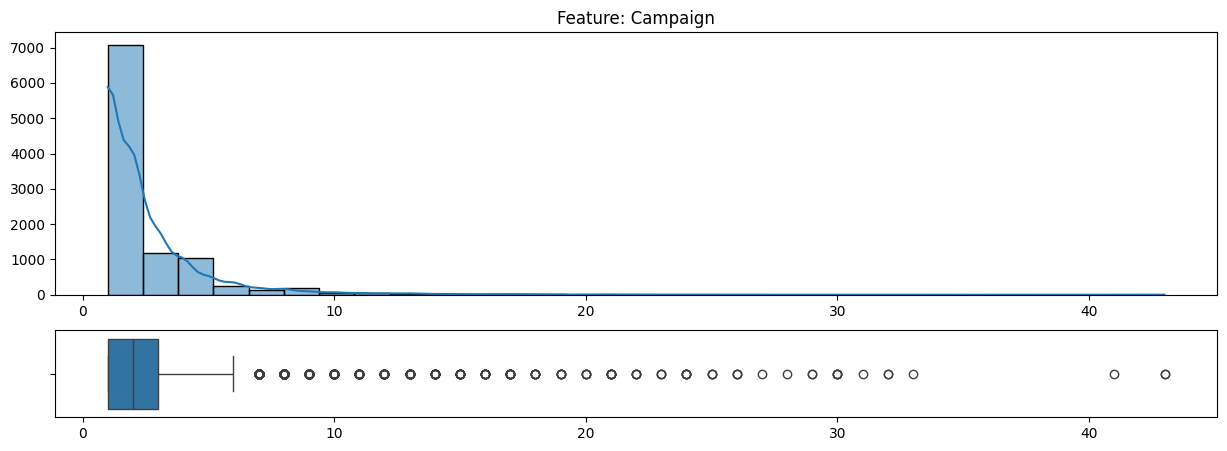

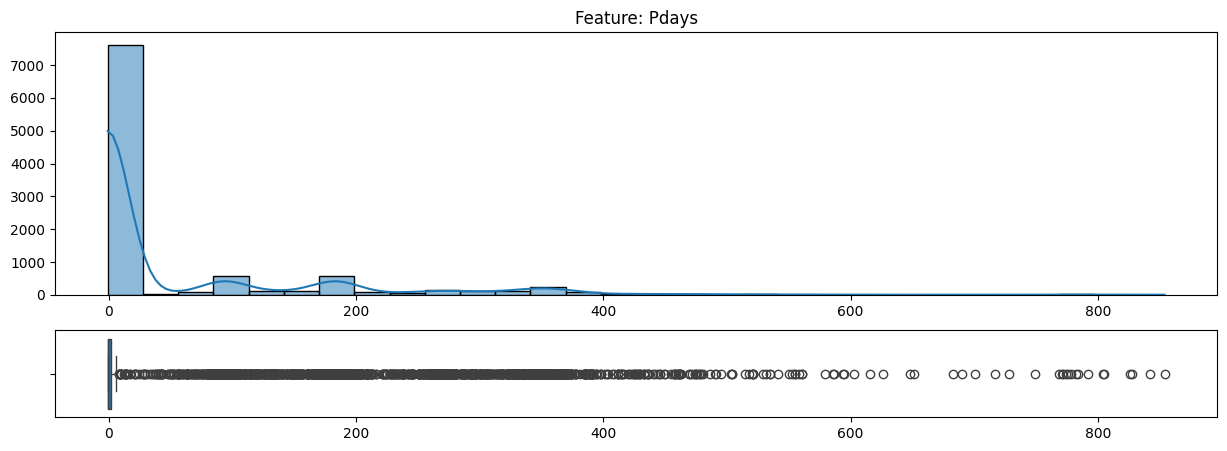

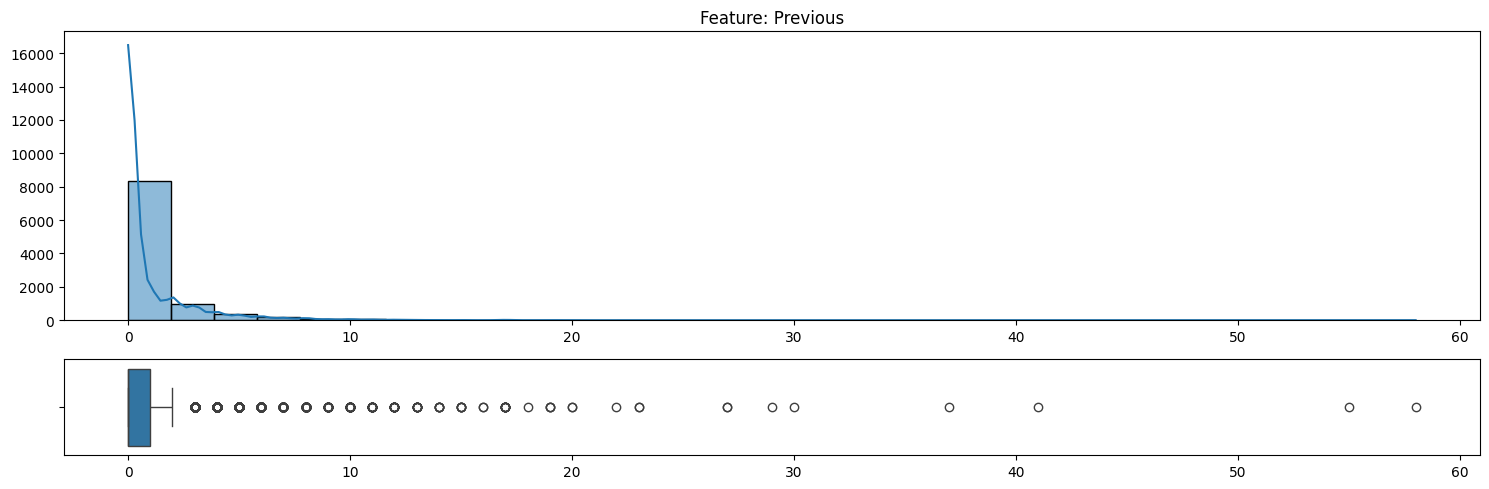

In [36]:
#loop through the features and create the graphs
for i, col in enumerate(numeric_features.index):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(15, 5),
                                          gridspec_kw={'height_ratios': (0.75, 0.25)})
    
    #set the parameters for the bar chart
    sns.histplot(data=df,
                 x=col,
                 bins=30,
                 kde=True,
                 ax=ax_hist)
    
    #set the parameters for the boxplot
    sns.boxplot(data=df,
                x=col,
                ax=ax_box)
    
    #set the title and axis for the histogram
    ax_hist.set(
        title='Feature:' + ' ' + str(col).capitalize(),
        ylabel='',
        xlabel=''
        )
    
    #set the title and axis for the boxplot
    ax_box.set(
        ylabel='',
        xlabel=''
        )
        
plt.tight_layout();
plt.show();

##### Задания 4 и 5

Попробуйте извлечь максимум информации из тех показателей, которые можете получить:

- Сколько всего сфер занятости представлено среди клиентов банка?
- В каждый ли месяц проходила маркетинговая кампания?
- Какое семейное положение встречается чаще всего?
- А образование?

Постарайтесь дать достаточно подробную интерпретацию. \
Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

Рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат.

In [37]:
#find the columns with a specific data type (excl. predictive feature)
categorical_features = [feature for feature in df.columns if ((df[feature].dtypes == 'object') & (feature not in ['deposit']))]

#show basic statistics for categorical features
df[categorical_features].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


Постройте визуализации, иллюстрирующие результаты.

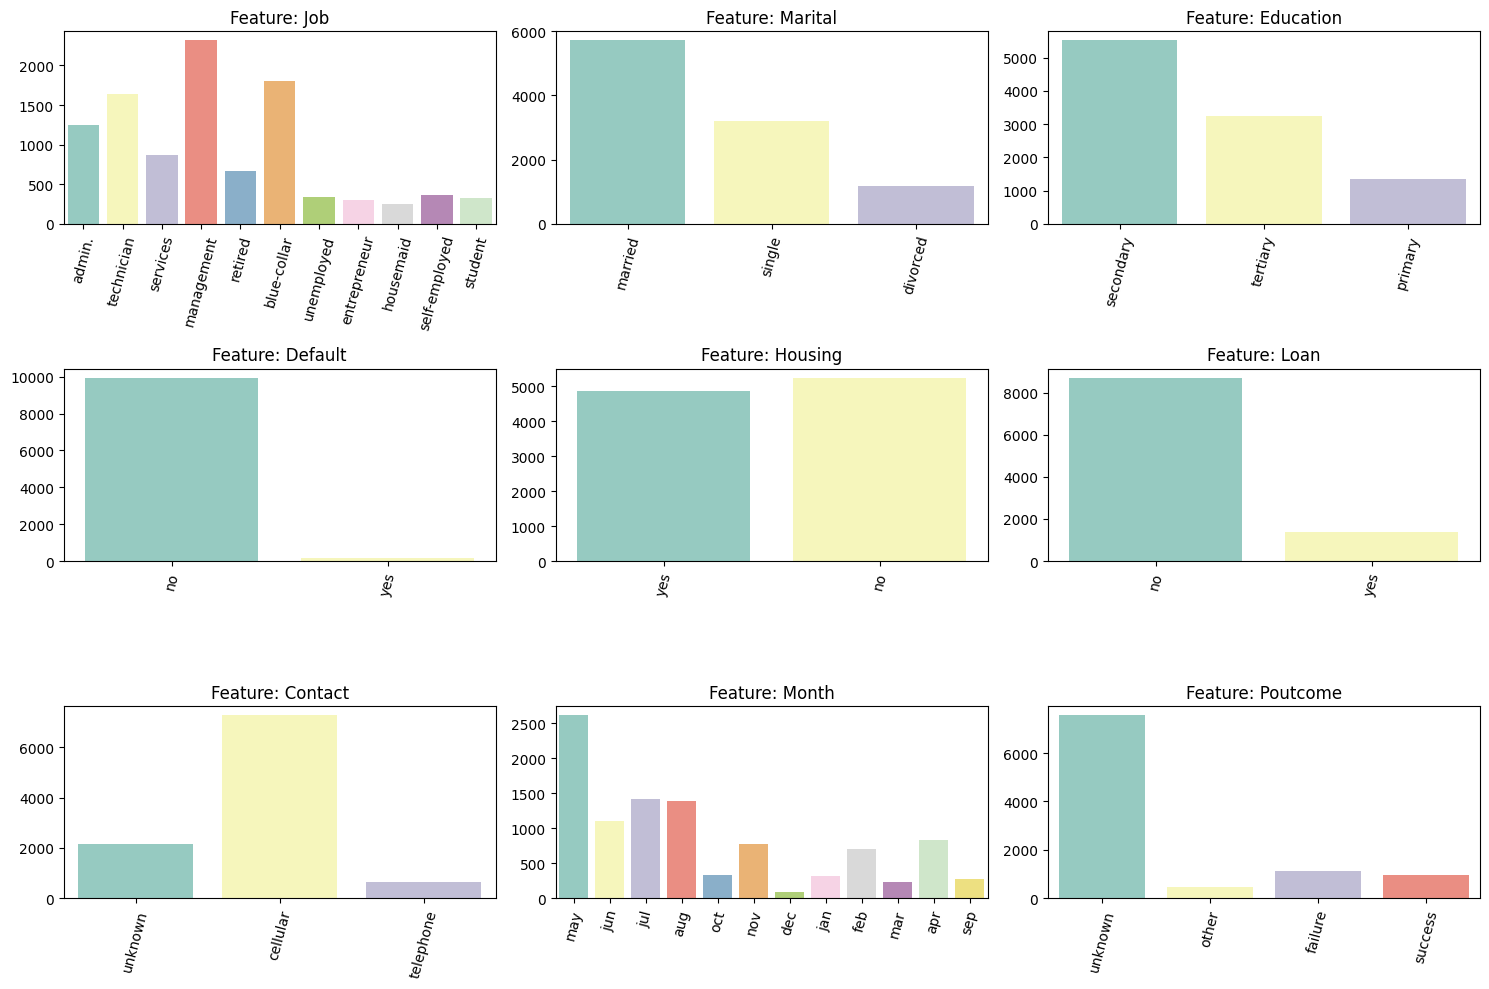

In [38]:
#set the canvas
plt.figure(figsize=(15, 10))

#set the starting cell point
i = 1

#loop through categorical features
for col in categorical_features:
    #set the number of rows / columns per graph on the canvas
    ax = plt.subplot(3, 3, i)
    sns.countplot(data=df,
                  x=col,
                  palette='Set3',
                  )
    
    #set the title and axis
    ax.set(title='Feature:' + ' ' + str(col).capitalize(),
           ylabel='',
           xlabel=''
           )
    
    #axis rotation for readability
    ax.xaxis.set_tick_params(rotation=75)

    #if row is full, move to the next row
    i += 1

plt.tight_layout()
plt.show();

##### Задание 6

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. \
Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. \
А возможно, ситуация ровно обратная. \
Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [39]:
#group post-outcome by the predictive feature
df.groupby('poutcome')['deposit'].value_counts().unstack()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


##### Задание 7

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. \
Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить.

Узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит.

In [40]:
refusal = df[df['deposit'] == 'no']
refusal.groupby('month')['poutcome'].value_counts().unstack().sort_values(by='failure', ascending=False)

poutcome,failure,other,success,unknown
month,,,,
may,217.0,66.0,13.0,1480.0
nov,92.0,22.0,14.0,328.0
apr,84.0,32.0,6.0,195.0
feb,71.0,36.0,10.0,206.0
jan,30.0,26.0,3.0,135.0
aug,19.0,10.0,13.0,733.0
oct,18.0,3.0,6.0,35.0
jun,10.0,3.0,11.0,582.0
sep,10.0,7.0,3.0,26.0


In [41]:
#group post-outcome by the predictive feature
(round(df.groupby('month')['deposit'].value_counts(normalize=True) * 100)).unstack().sort_values(by='no', ascending=False)[:5]

deposit,no,yes
month,,
may,68.0,32.0
jan,61.0,39.0
jul,59.0,41.0
nov,58.0,42.0
aug,56.0,44.0


##### Задание 8

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

        '<30';
        '30-40';
        '40-50';
        '50-60';
        '60+'.

Создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения.

In [42]:
#encode age as a category
age_conditions = [df['age'] < 30,
                  df['age'].between(30, 39),
                  df['age'].between(40, 49),
                  df['age'].between(50, 59),
                  df['age'] >= 60]

age_cat = ['<30', '30-40', '40-50', '50-60', '60+']

df['age_category'] = np.select(age_conditions, age_cat)

Совет. \
После создания этой переменной постройте диаграмму (на ваш вкус), которая, с вашей точки зрения, сможет наилучшим образом отобразить различия в количестве открытых/не открытых депозитов для каждой возрастной группы.

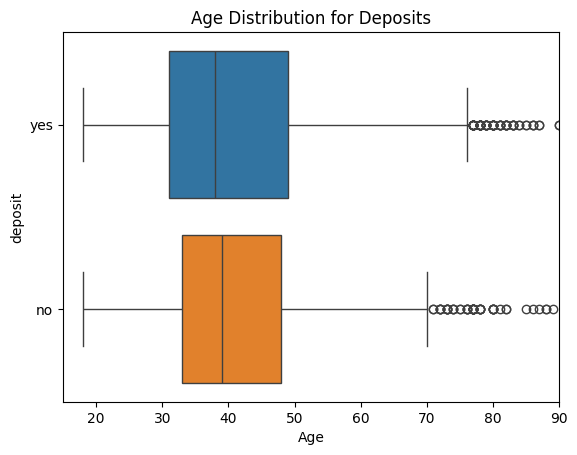

In [43]:
#create a boxplot
ax = sns.boxplot(data=df,
                 x='age',
                 y='deposit',
                 hue='deposit')

ax.set_title('Age Distribution for Deposits')
ax.set_xlabel('Age')
ax.set_xlim(15, 90);

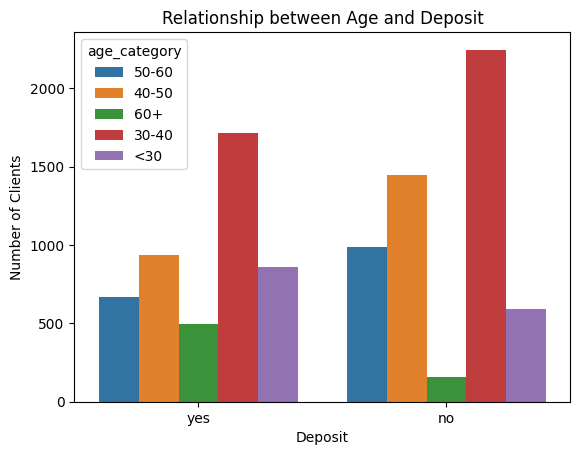

In [44]:
#create a countplot
ax = sns.countplot(data=df,
                   x=df['deposit'],
                   hue='age_category')
ax.set(xlabel='Deposit',
       ylabel='Number of Clients')
plt.title('Relationship between Age and Deposit')
plt.show()

In [45]:
#group age category by the predictive feature
mask_yes = df[df['deposit'] == 'yes']
mask_no = df[df['deposit'] == 'no']

df.groupby('age_category')['deposit'].value_counts().unstack()

deposit,no,yes
age_category,,
30-40,2245,1716
40-50,1444,938
50-60,984,670
60+,157,496
<30,594,861


In [46]:
import more_itertools

#convert arrays into lists
deeply_nested_list_y = mask_yes.groupby('age_category')['deposit'].value_counts().unstack().values.tolist()
deeply_nested_list_n = mask_no.groupby('age_category')['deposit'].value_counts().unstack().values.tolist()

#import the data for the graph
yes_age = list(more_itertools.collapse(deeply_nested_list_y))
no_age = list(more_itertools.collapse(deeply_nested_list_n))

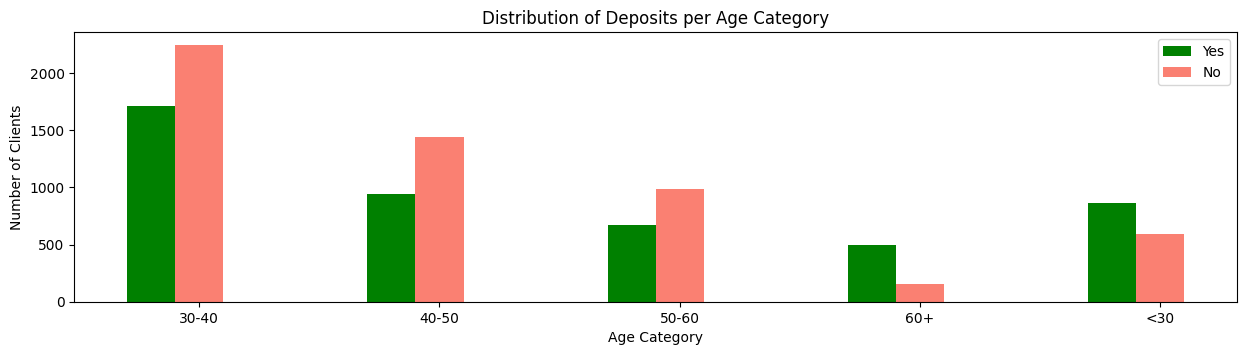

In [104]:
#set the number of marks 
x = np.arange(5)

#set the space between bar width
width = 0.2

#set the canvas
plt.figure(figsize=(15, 3.5))

#create a bar chart for deposit = 'yes'
plt.bar(x-0.2,
        yes_age,
        width,
        color='green')

#create a bar chart for deposit = 'no'
plt.bar(x,
        no_age,
        width,
        color='salmon')

plt.title('Distribution of Deposits per Age Category')
plt.xticks(x, ['30-40', '40-50', '50-60', '60+', '<30'])
plt.xlabel('Age Category')
plt.ylabel('Number of Clients')
plt.legend(['Yes', 'No'])
plt.show()

##### Задания 9 и 10

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

	▪	семейное положение;
	▪	уровень образования;
	▪	сфера занятости.

Постройте визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постарайтесь оформить диаграммы максимально наглядно и описать полученный результат.
К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

Постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса.

(a) **Marital Status**

In [48]:
#group marital status by the predictive feature
df.groupby('marital')['deposit'].value_counts().unstack()

deposit,no,yes
marital,,
divorced,624,553
married,3303,2412
single,1497,1716


In [49]:
#convert arrays into lists
nested_list_ym = mask_yes.groupby('marital')['deposit'].value_counts().unstack().values.tolist()
nested_list_nm = mask_no.groupby('marital')['deposit'].value_counts().unstack().values.tolist()

#import the data for the graph
yes_marital = list(more_itertools.collapse(nested_list_ym))
no_marital = list(more_itertools.collapse(nested_list_nm))

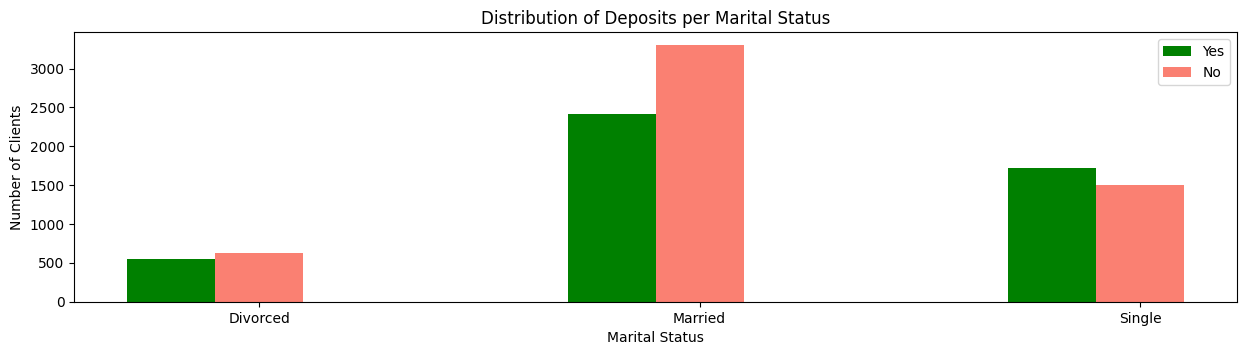

In [103]:
#set the number of marks
x = np.arange(3)

#set the space between bar width
width = 0.2

#set the canvas
plt.figure(figsize=(15, 3.5))

#create a bar chart for deposit = 'yes'
plt.bar(x-0.2,
        yes_marital,
        width,
        color='green')

#create a bar chart for deposit = 'no'
plt.bar(x,
        no_marital,
        width,
        color='salmon')

plt.title('Distribution of Deposits per Marital Status')
plt.xticks(x, ['Divorced', 'Married', 'Single'])
plt.xlabel('Marital Status')
plt.ylabel('Number of Clients')
plt.legend(['Yes', 'No'])
plt.show()

Постройте визуализации для открывших и неоткрывших депозит в зависимости от образования.

(b) **Education**

In [51]:
#group education by the predictive feature
df.groupby('education')['deposit'].value_counts().unstack()

deposit,no,yes
education,,
primary,832,517
secondary,3066,2451
tertiary,1526,1713


In [52]:
#convert arrays into lists
nested_list_y = mask_yes.groupby('education')['deposit'].value_counts().unstack().values.tolist()
nested_list_n = mask_no.groupby('education')['deposit'].value_counts().unstack().values.tolist()

#import the data for the graph
yes_educ = list(more_itertools.collapse(nested_list_y))
no_educ = list(more_itertools.collapse(nested_list_n))

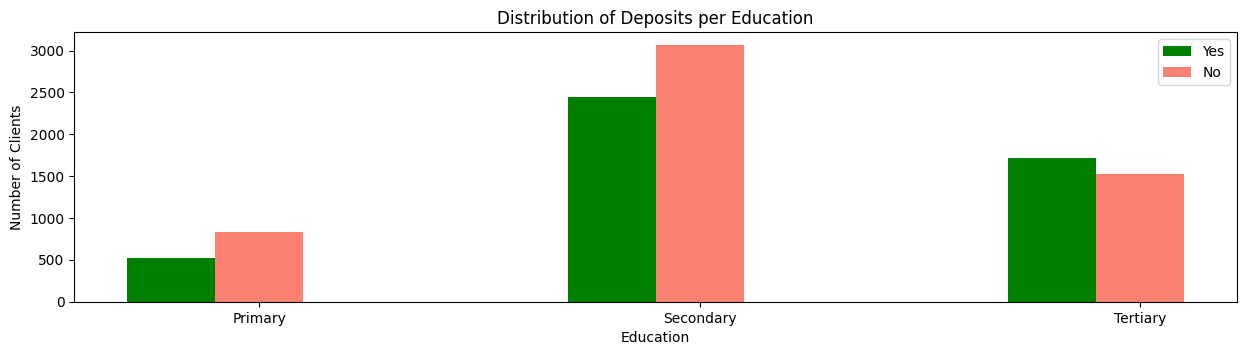

In [102]:
#set the number of marks
x = np.arange(3)

#set the space between bar width
width = 0.2

#set the canvas
plt.figure(figsize=(15, 3.5))

#create a bar chart for deposit = 'yes'
plt.bar(x-0.2,
        yes_educ,
        width,
        color='green')

#create a bar chart for deposit = 'no'
plt.bar(x,
        no_educ,
        width,
        color='salmon')

plt.title('Distribution of Deposits per Education')
plt.xticks(x, ['Primary', 'Secondary', 'Tertiary'])
plt.xlabel('Education')
plt.ylabel('Number of Clients')
plt.legend(['Yes', 'No'])
plt.show()


Постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости.

(c) **Job**

In [54]:
#group job by the predictive feature
df.groupby('job')['deposit'].value_counts().unstack()

deposit,no,yes
job,,
admin.,672,574
blue-collar,1155,652
entrepreneur,189,111
housemaid,153,99
management,1180,1135
retired,231,432
self-employed,197,161
services,523,345
student,81,245


In [55]:
#convert arrays into lists
nested_list_yj = mask_yes.groupby('job')['deposit'].value_counts().unstack().values.tolist()
nested_list_nj = mask_no.groupby('job')['deposit'].value_counts().unstack().values.tolist()

#import the data for the graph
yes_job = list(more_itertools.collapse(nested_list_yj))
no_job = list(more_itertools.collapse(nested_list_nj))

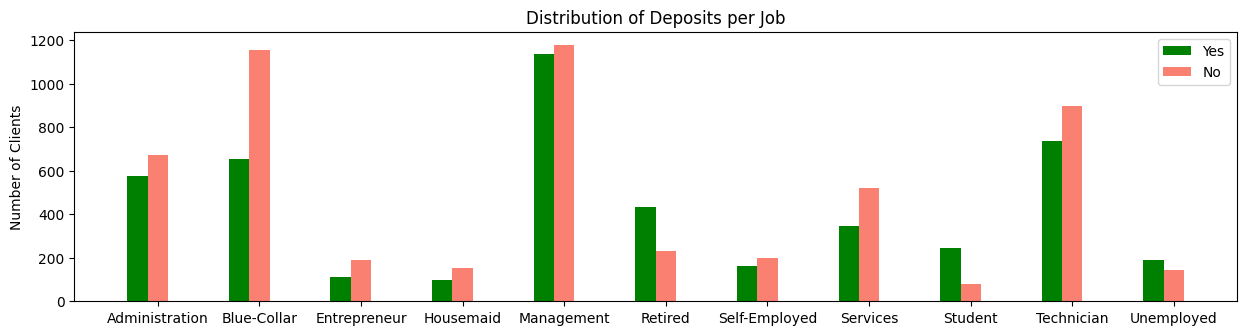

In [105]:
#set the number of marks
x = np.arange(11)

#set the space between bar width
width = 0.2

#set the canvas
plt.figure(figsize=(15, 3.5))

#create a bar chart for deposit = 'yes'
plt.bar(x-0.2,
        yes_job,
        width,
        color='green')

#create a bar chart for deposit = 'no'
plt.bar(x,
        no_job,
        width,
        color='salmon')

plt.title('Distribution of Deposits per Job')
plt.xticks(x, ['Administration', 'Blue-Collar', 'Entrepreneur', 'Housemaid', 'Management', 'Retired',
               'Self-Employed', 'Services', 'Student', 'Technician', 'Unemployed'])
plt.xlabel('')
plt.ylabel('Number of Clients')
plt.legend(['Yes', 'No'])
plt.show()

##### Задание 11

Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования? \
Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. \
Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

Постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны.

In [57]:
#create pivot tables
deposit_yes = mask_yes.pivot_table(
    values = 'deposit',
    index = 'education',
    columns='marital',
    aggfunc='count'
)

deposit_no = mask_no.pivot_table(
    values = 'deposit',
    index = 'education',
    columns='marital',
    aggfunc='count'
)

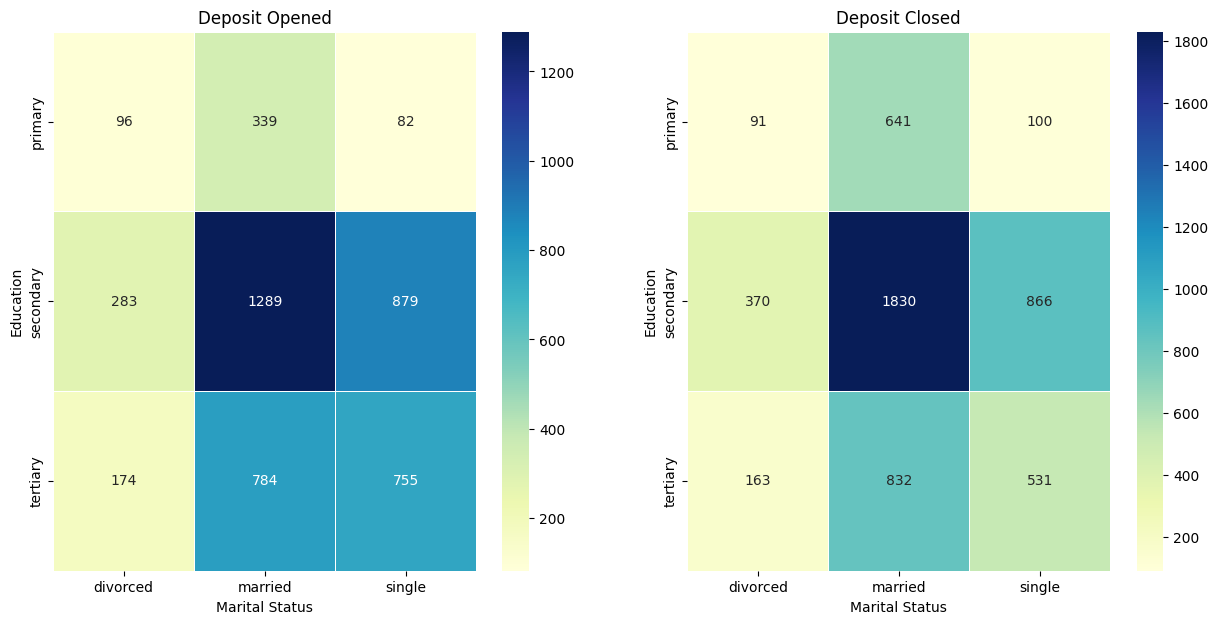

In [114]:
#set the canvas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

#for deposit = 'yes'
ax1 = sns.heatmap(
    data=deposit_yes,
    cmap='YlGnBu',
    annot=True,
    fmt='g',
    linewidth=.5,
    ax=ax1
)

#set the title and axis
ax1.set_title('Deposit Opened', fontsize=12)
ax1.set_xlabel('Marital Status')
ax1.set_ylabel('Education');


#for deposit = 'no'
ax2 = sns.heatmap(
    data=deposit_no,
    cmap='YlGnBu',
    annot=True,
    fmt='g',
    linewidth=.5,
    ax=ax2
)

#set the title and axis
ax2.set_title('Deposit Closed', fontsize=12)
ax2.set_xlabel('Marital Status')
ax2.set_ylabel('Education');

## **Часть 3**: Преобразование Данных

##### Задание 1

Преобразуйте уровни образования

In [59]:
#create the object class
label_encoder = preprocessing.LabelEncoder()

#encode the feature
df['education'] = label_encoder.fit_transform(df['education'])

In [60]:
#find the sum of the education attribute
df['education'].sum()

11995

Ранее мы создали порядковую переменную для возраста. \
Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [61]:
#encode the feature
df['age_category'] = label_encoder.fit_transform(df['age_category'])

##### Задания 2 и 3

Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. \
Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [62]:
#convert the predictive feature into a binary column
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [63]:
#find the standard deviation for the predictive feature
df['deposit'].std().round(3)

0.499

Сделаем то же самое для других бинарных переменных, которых у нас три:

        'default';
        'housing';
        'loan'.

Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [64]:
#convert binary columns for other features
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

Calculate the arithmetic mean for each of the resulting variables, add the three results and enter the total rounding it to three decimal places.

In [65]:
round((df['default'].mean() + df['housing'].mean() + df['loan'].mean()), 3)

0.635

In [66]:
round(sum([df['default'].mean(), df['housing'].mean(), df['loan'].mean()]), 3)

0.635

##### Задание 4

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

        'job';
        'marital';
        'contact';
        'month';
        'poutcome'.

Создайте для них dummy-переменные и добавьте их в набор данных.

In [67]:
#create a list of categorical columns
columns_to_encode = ['job', 'marital', 'contact', 'month', 'poutcome']

#encode the features
df_dummies = pd.get_dummies(df[columns_to_encode])

#combine with the main data set
df = pd.concat([df, df_dummies],
               axis=1)

In [68]:
#new total number of records / features
df.shape

(10105, 51)

In [69]:
#delete unnecessary features
df = df.drop(columns=columns_to_encode,
             axis=1,
             errors='ignore')

##### Задания 5 и 6

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

Постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности.

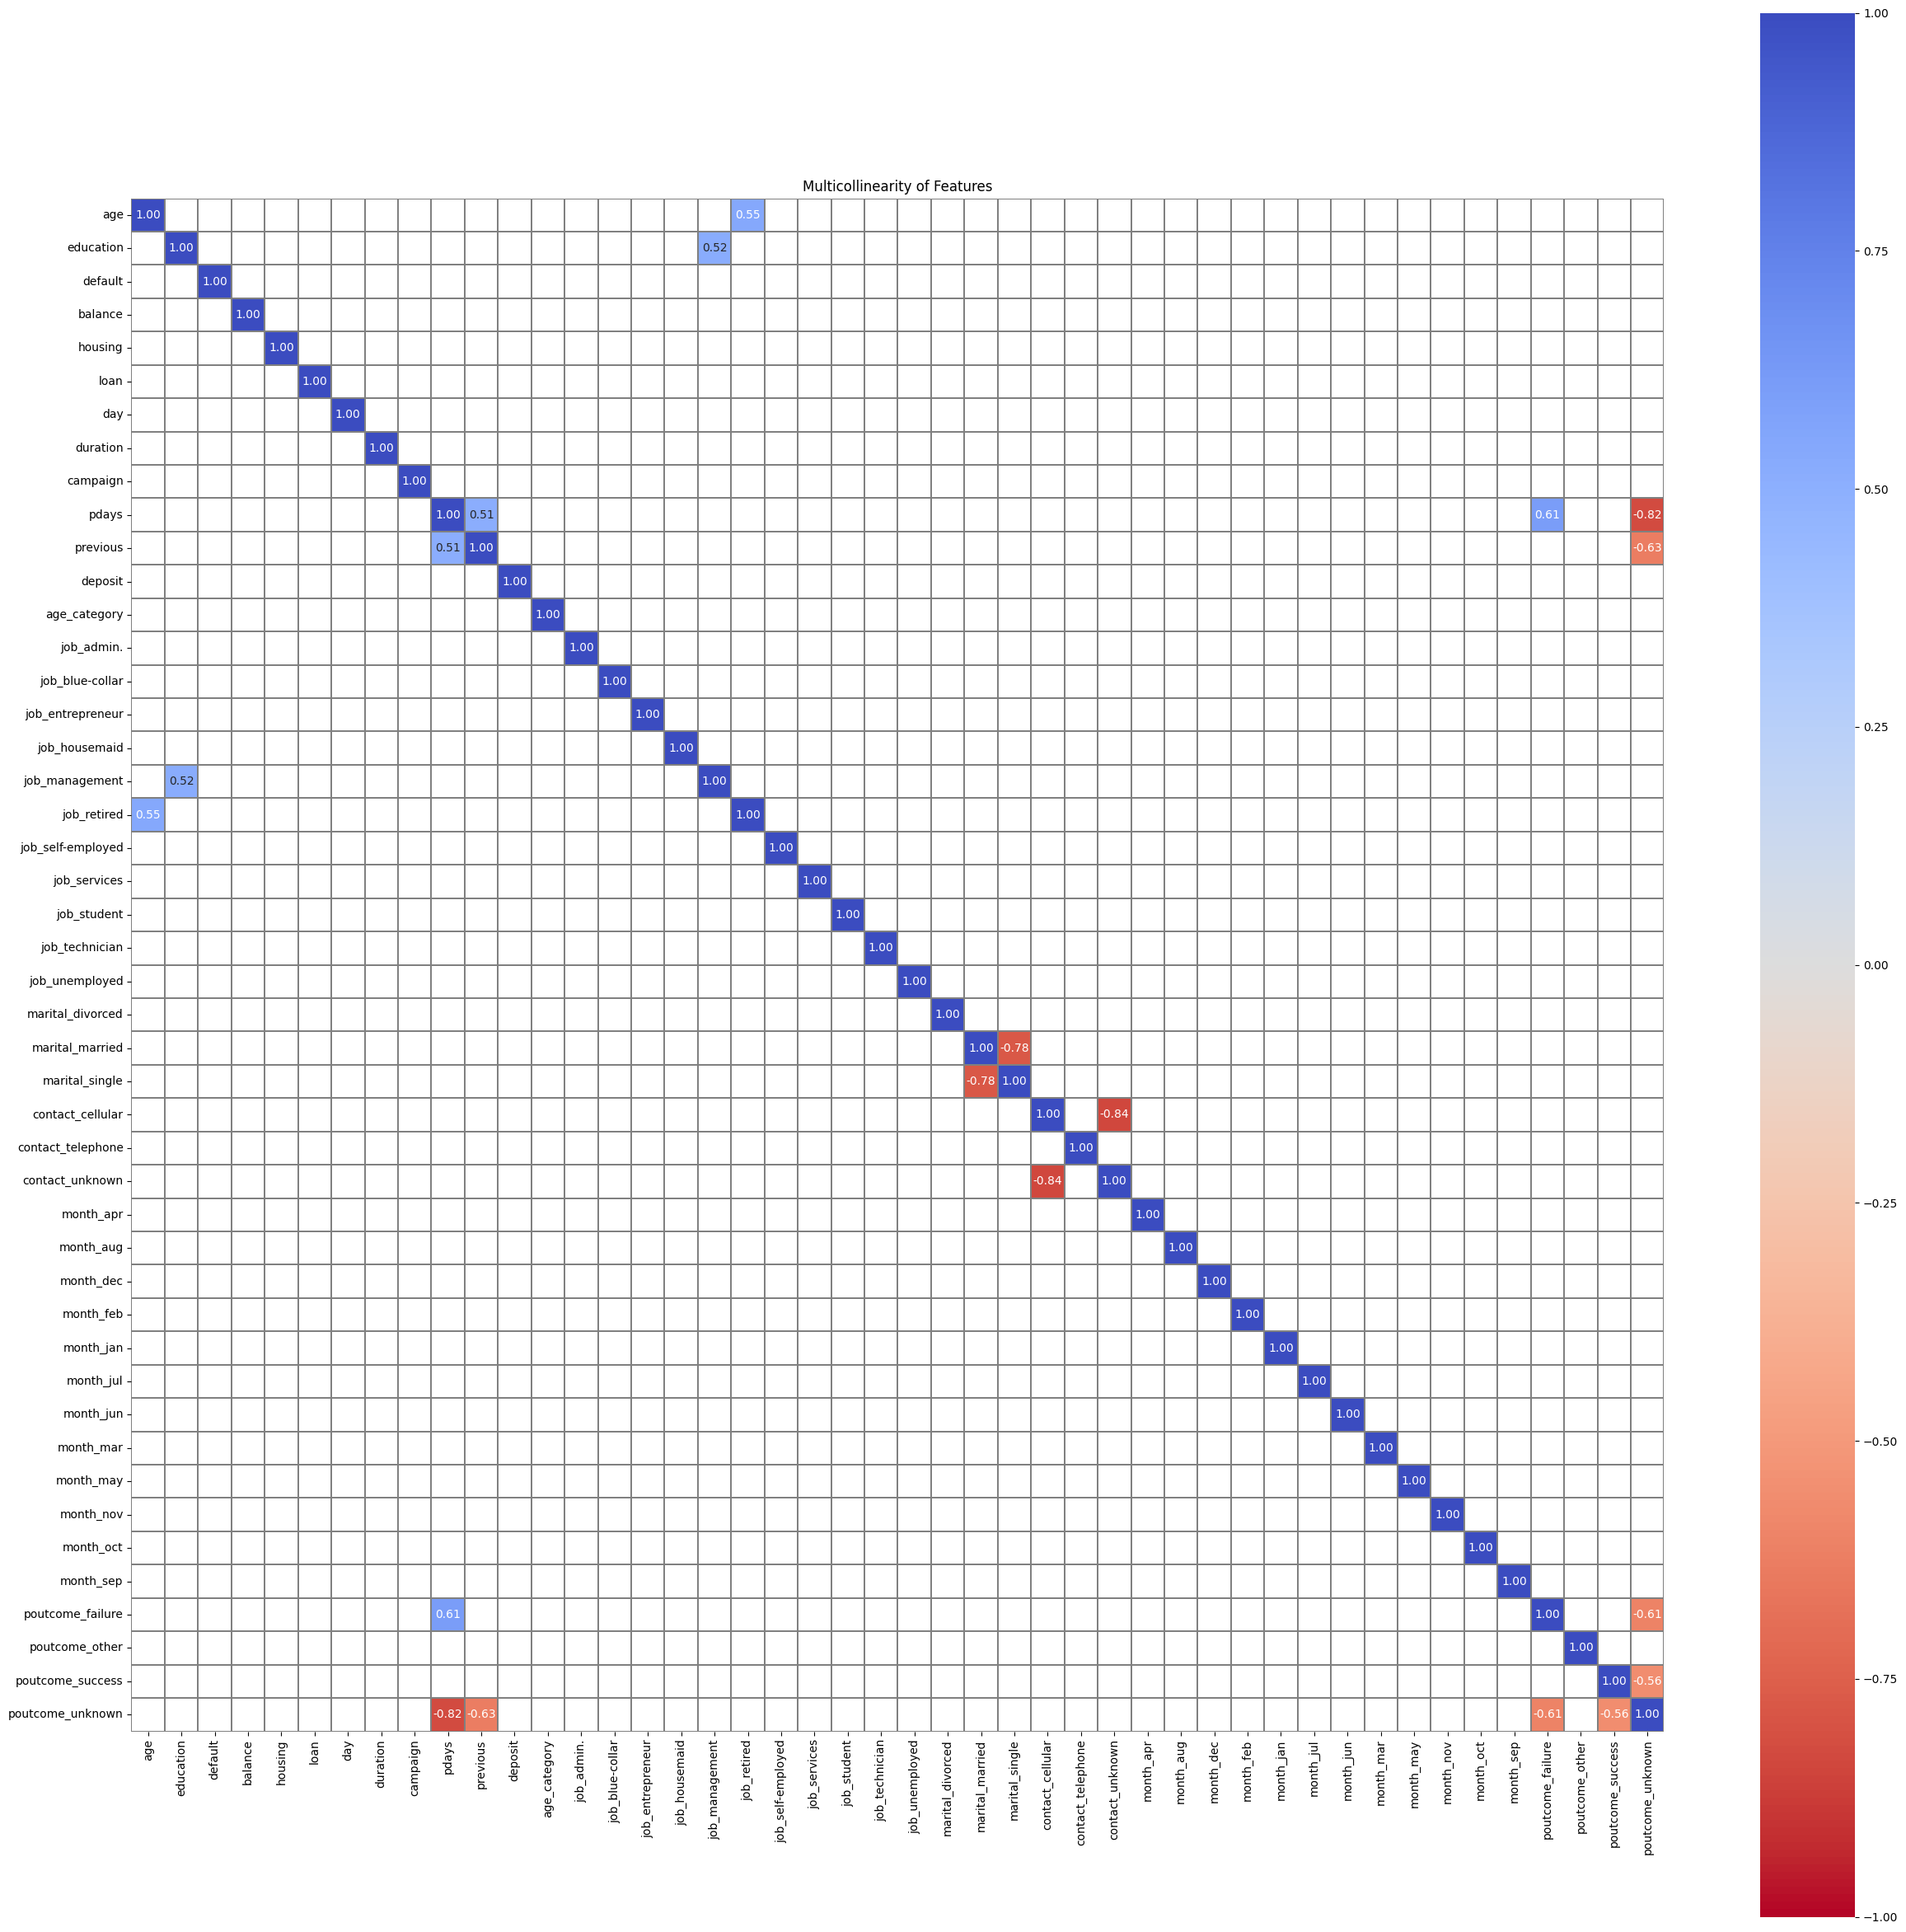

In [70]:
#create the pearson's correlation
num_corr = df.corr()

#set the canvas
plt.subplots(figsize=(30, 30))

ax = sns.heatmap(
    num_corr[num_corr.abs() >= 0.5],
    #num_corr,
    vmin=-1, 
    vmax=1, 
    linewidth=0.05, 
    linecolor='gray', 
    cmap='coolwarm_r',
    annot = True,
    fmt='.2f',
    square=True
)

#set the title
ax.set_title('Multicollinearity of Features');

В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

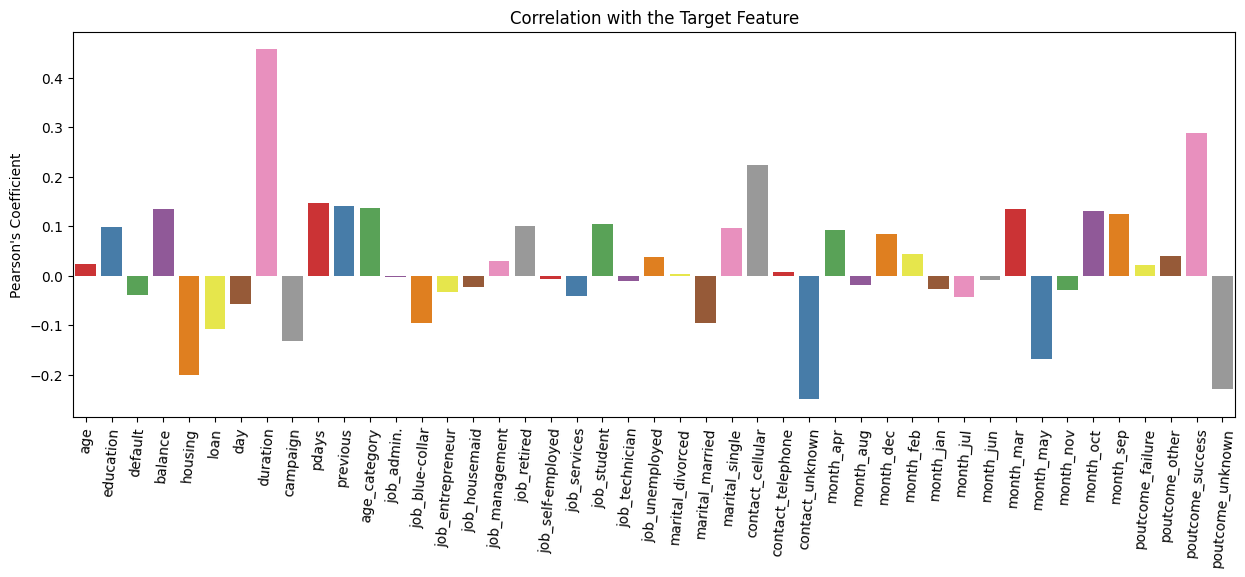

In [71]:
#to use in the chart
bar_data = num_corr.drop('deposit')

#set the canvas
fig = plt.figure(figsize=(15, 5))

#create the bar chart
ax = sns.barplot(
    bar_data.reset_index(),
    x='index', 
    y='deposit',
    palette='Set1'
)

#set the marks rotation for readability
ax.xaxis.set_tick_params(rotation=85)

#set the title and axis
ax.set(title='Correlation with the Target Feature', 
    xlabel='',
    ylabel="Pearson's Coefficient"
);

##### Задания 7 и 8

Теперь вам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0.33. Не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.

In [72]:
#select the features
X = df.drop(['deposit'],
            axis=1)
y = df['deposit']

#split the data set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    stratify=y,
                                                                    random_state=42,
                                                                    test_size=0.33)

Каким получился размер выборки?

In [73]:
print(f'Train X: {X_train.shape}')
print(f'Train y: {y_train.shape}')
print()
print(f'Test X: {X_test.shape}')
print(f'Test y: {y_test.shape}')

Train X: (6770, 45)
Train y: (6770,)

Test X: (3335, 45)
Test y: (3335,)


Каково среднее значение целевой переменной на тестовой выборке?

In [74]:
y_test.mean().round(2)

0.46

##### Задание 9

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

In [75]:
#find the best features using KBest
selector_kbest = feature_selection.SelectKBest(feature_selection.f_classif,
                                               k=15)

#model learning
selector_kbest.fit(X_train, y_train)

#display the selected features
kbest_columns = list(selector_kbest.get_feature_names_out())
kbest_columns

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_category',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [76]:
#select the best features
X_train = X_train[kbest_columns]
X_test = X_test[kbest_columns]

##### Задание 10

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

Помните, что нормализация требуется для предикторов, а не для целевой переменной.

Нормализуйте предикторы в обучающей и тестовой выборках.

In [77]:
#initialize the normalizer
min_max_scaler = preprocessing.MinMaxScaler()

#normalize the data
min_max_scaler.fit(X_train)

#tranform the train / test data
X_train_scaled = min_max_scaler.transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки.

In [78]:
X_test_scaled[:, 0].mean().round(2)

0.47

## **Часть 4**: Решение Задачи Классификации
## Логистическая Регрессия и Решающие Деревья

##### Задание 1

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. \
В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

**Logistic Regression Model**

In [79]:
#create the object class
log_reg = linear_model.LogisticRegression(
    max_iter=1000,
    solver='sag',
    random_state=42
)

#model learning
log_reg.fit(X_train_scaled, y_train)

#make prediction for both sets of data: train / test
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)

#display the classification metrics
print('Train Classification Metrics:')
print(metrics.classification_report(y_train, y_pred_train, digits=3))

print(sep='/n')

print('Test Classification Metrics:')
print(metrics.classification_report(y_test, y_pred_test, digits=3))

Train Classification Metrics:
              precision    recall  f1-score   support

           0      0.811     0.878     0.843      3634
           1      0.843     0.762     0.801      3136

    accuracy                          0.824      6770
   macro avg      0.827     0.820     0.822      6770
weighted avg      0.826     0.824     0.823      6770


Test Classification Metrics:
              precision    recall  f1-score   support

           0      0.790     0.866     0.826      1790
           1      0.825     0.734     0.777      1545

    accuracy                          0.805      3335
   macro avg      0.808     0.800     0.802      3335
weighted avg      0.807     0.805     0.804      3335



##### Задания 2-4

Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

        criterion = 'entropy';
        random_state = 42.

Остальные параметры оставьте по умолчанию.

**Decision Tree Model**

In [80]:
#create the object class
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

#model learning by CART algorithm
decision_tree.fit(X_train_scaled, y_train)

#make class prediction for both sets of data: train / test
y_train_pred_dt = decision_tree.predict(X_train_scaled)
y_test_pred_dt = decision_tree.predict(X_test_scaled)

#display the classification metrics
print('Train Classification Metrics:')
print(metrics.classification_report(y_train, y_train_pred_dt, digits=3))

print(sep='\n')

print('Test Classification Metrics:')
print(metrics.classification_report(y_test, y_test_pred_dt, digits=3))

Train Classification Metrics:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3634
           1      1.000     1.000     1.000      3136

    accuracy                          1.000      6770
   macro avg      1.000     1.000     1.000      6770
weighted avg      1.000     1.000     1.000      6770


Test Classification Metrics:
              precision    recall  f1-score   support

           0      0.756     0.781     0.768      1790
           1      0.736     0.708     0.722      1545

    accuracy                          0.747      3335
   macro avg      0.746     0.745     0.745      3335
weighted avg      0.747     0.747     0.747      3335



In [81]:
#find the depth level of the decision tree
print(f'find the depth level of the decision tree: {decision_tree.get_depth()}')

find the depth level of the decision tree: 36


In [82]:
#create the object class
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    random_state=42
)

#model learning by CART algorithm
decision_tree.fit(X_train_scaled, y_train)

#make class prediction for both sets of data: train / test
y_train_pred_dt = decision_tree.predict(X_train_scaled)
y_test_pred_dt = decision_tree.predict(X_test_scaled)

#display the classification metrics
print('Train Classification Metrics:')
print(metrics.classification_report(y_train, y_train_pred_dt, digits=3))

print(sep='\n')

print('Test Classification Metrics:')
print(metrics.classification_report(y_test, y_test_pred_dt, digits=3))

Train Classification Metrics:
              precision    recall  f1-score   support

           0      0.861     0.789     0.823      3634
           1      0.777     0.853     0.813      3136

    accuracy                          0.818      6770
   macro avg      0.819     0.821     0.818      6770
weighted avg      0.822     0.818     0.819      6770


Test Classification Metrics:
              precision    recall  f1-score   support

           0      0.851     0.781     0.814      1790
           1      0.768     0.841     0.803      1545

    accuracy                          0.809      3335
   macro avg      0.810     0.811     0.809      3335
weighted avg      0.813     0.809     0.809      3335



##### Задание 5

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

        'min_samples_split': [2, 5, 7, 10];
        'max_depth':[3,5,7].

In [83]:
#set the search grid for decision tree hyperparameters
param_grid = {'max_depth': [3, 5, 7],
              'min_samples_leaf': [2, 5, 7, 10],
              }

**Decision Tree Model**

In [84]:
#use the grid search to look for hyperparameters
grid_search_tree = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    verbose=10,
    n_jobs=-1
)

#find the processing time
%time grid_search_tree.fit(X_train_scaled, y_train)

#make a prediction
y_train_pred_gs = grid_search_tree.predict(X_train_scaled)
y_test_pred_gs = grid_search_tree.predict(X_test_scaled)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 4/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 1/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 3/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 2/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 3/5; 1/12] END max_depth=3, min_samples_leaf=2;, score=0.790 total time=   0.0s
[CV 4/5; 1/12] END max_depth=3, min_samples_leaf=2;, score=0.778 total time=   0.0s
[CV 1/5; 1/12] END max_depth=3, min_samples_leaf=2;, score=0.768 total time=   0.0s
[CV 2/5; 1/12] END max_depth=3, min_samples_leaf=2;, score=0.786 total time=   0.0s
[CV 5/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 4/5; 2/12] START max_depth=3, min_samples_leaf=5............................
[CV 5/5; 2/12] START max_depth=3, min_samples_leaf=5............................
[CV 1/5; 3/12] START max_depth=3, mi

In [85]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_gs):.3f}')
print(f'accuracy: {grid_search_tree.score(X_train_scaled, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_gs):.3f}')
print(f'accuracy: {grid_search_tree.score(X_test_scaled, y_test):.3f}')
print()
print('best found hyperparameters for decision tree using grid search:')
print(grid_search_tree.best_params_)

train data:
f1_score: 0.818
accuracy: 0.832

test data
f1_score: 0.803
accuracy: 0.816

best found hyperparameters for decision tree using grid search:
{'max_depth': 7, 'min_samples_leaf': 10}


**Random Forest Model**

In [86]:
#use the grid search to look for hyperparameters
grid_search_forest = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    verbose=10,
    n_jobs=-1
)

#find the processing time
%time grid_search_forest.fit(X_train_scaled, y_train)

#make a prediction
y_train_pred_gs_rf = grid_search_forest.predict(X_train_scaled)
y_test_pred_gs_rf = grid_search_forest.predict(X_test_scaled)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 2/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 3/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 1/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 4/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 5/5; 1/12] START max_depth=3, min_samples_leaf=2............................
[CV 1/5; 2/12] START max_depth=3, min_samples_leaf=5............................
[CV 2/5; 2/12] START max_depth=3, min_samples_leaf=5............................
[CV 3/5; 2/12] START max_depth=3, min_samples_leaf=5............................
[CV 4/5; 1/12] END max_depth=3, min_samples_leaf=2;, score=0.803 total time=   0.2s
[CV 5/5; 1/12] END max_depth=3, min_samples_leaf=2;, score=0.818 total time=   0.2s
[CV 4/5; 2/12] START max_depth=3, min_samples_leaf=5............................
[CV 3/5; 1/12] END max_depth=3, min_sample

In [87]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_gs_rf):.3f}')
print(f'accuracy: {grid_search_forest.score(X_train_scaled, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_gs_rf):.3f}')
print(f'accuracy: {grid_search_forest.score(X_test_scaled, y_test):.3f}')
print()
print('best found hyperparameters for random forest using grid search:')
print(grid_search_forest.best_params_)

train data:
f1_score: 0.835
accuracy: 0.846

test data
f1_score: 0.811
accuracy: 0.822

best found hyperparameters for random forest using grid search:
{'max_depth': 7, 'min_samples_leaf': 2}


## **Часть 5**: Решение Задачи Классификации
## Ансамбли Моделей и Построение Прогноза

##### Задание 1

**Random Forest Model**

Обучите случайный лес со следующими параметрами:

        n_estimators = 100;
        criterion = 'gini';
        min_samples_leaf = 5;
        max_depth = 10;
        random_state = 42.

In [88]:
#create an object class
random_forest = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

#model learning
random_forest.fit(X_train_scaled, y_train)

#make a prediction
y_train_pred_rf = random_forest.predict(X_train_scaled)
y_test_pred_rf = random_forest.predict(X_test_scaled)

#display the metrics
print('train data:')
print(f'f1 score: {metrics.f1_score(y_train, y_train_pred_rf):.3f}')
print(f'accuracy: {metrics.accuracy_score(y_train, y_train_pred_rf):.3f}')
print(f'recall: {metrics.recall_score(y_train, y_train_pred_rf):.3f}')
print()
print('test data:')
print(f'f1 score: {metrics.f1_score(y_test, y_test_pred_rf):.3f}')
print(f'accuracy: {metrics.accuracy_score(y_test, y_test_pred_rf):.3f}')
print(f'recall: {metrics.recall_score(y_test, y_test_pred_rf):.3f}')

train data:
f1 score: 0.849
accuracy: 0.858
recall: 0.860

test data:
f1 score: 0.818
accuracy: 0.828
recall: 0.833


##### Задания 2-3

**Gradient Boosting**

Data Scientist не должен останавливаться на одной модели — он должен пробовать все доступные варианты. \
Поэтому теперь предлагаем вам сравнить полученные результаты с моделью градиентного бустинга. Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

        learning_rate = 0.05;
        n_estimators = 300;
        min_samples_leaf = 5;
        max_depth = 5;
        random_state = 42.

In [89]:
#create the object class
gradient_boosting = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

#model learning
gradient_boosting.fit(X_train_scaled, y_train)

#make a prediction
y_pred_train_gb = gradient_boosting.predict(X_train_scaled)
y_pred_test_gb = gradient_boosting.predict(X_test_scaled)

#display the classification metrics
print('Train Classification Metrics:')
print(metrics.classification_report(y_train, y_pred_train_gb, digits=3))

print(sep='\n')

print('Test Classification Metrics:')
print(metrics.classification_report(y_test, y_pred_test_gb, digits=3))

Train Classification Metrics:
              precision    recall  f1-score   support

           0      0.901     0.888     0.895      3634
           1      0.873     0.887     0.880      3136

    accuracy                          0.888      6770
   macro avg      0.887     0.888     0.887      6770
weighted avg      0.888     0.888     0.888      6770


Test Classification Metrics:
              precision    recall  f1-score   support

           0      0.850     0.822     0.836      1790
           1      0.802     0.832     0.817      1545

    accuracy                          0.827      3335
   macro avg      0.826     0.827     0.826      3335
weighted avg      0.828     0.827     0.827      3335



##### Задание 4

**Stacking**

Вы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

В этом задании вам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

In [90]:
#create a tuple with (model name, model class)
estimators = [
    ('dt', decision_tree),
    ('lr', log_reg),
    ('gb', gradient_boosting)
]

#create an object class
stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=log_reg
)

#model learning
%time stack.fit(X_train_scaled, y_train)

#make a prediction
y_pred_train_stack = stack.predict(X_train_scaled)
y_pred_test_stack = stack.predict(X_test_scaled)

#display the classification metrics
print('Train Classification Metrics:')
print(metrics.classification_report(y_train, y_pred_train_stack, digits=3))

print(sep='\n')

print('Test Classification Metrics:')
print(metrics.classification_report(y_test, y_pred_test_stack, digits=3))

CPU times: user 18.8 s, sys: 61.7 ms, total: 18.9 s
Wall time: 16.9 s
Train Classification Metrics:
              precision    recall  f1-score   support

           0      0.878     0.881     0.879      3634
           1      0.862     0.858     0.860      3136

    accuracy                          0.870      6770
   macro avg      0.870     0.869     0.870      6770
weighted avg      0.870     0.870     0.870      6770


Test Classification Metrics:
              precision    recall  f1-score   support

           0      0.834     0.830     0.832      1790
           1      0.804     0.809     0.807      1545

    accuracy                          0.820      3335
   macro avg      0.819     0.820     0.819      3335
weighted avg      0.820     0.820     0.820      3335



##### Задание 5

In [91]:
# evaluate which features show the most importance in a gradient boosting model
sorted(list(zip(kbest_columns, np.round(gradient_boosting.feature_importances_, 3))),
       key=lambda x: x[1],
       reverse=True
)[:3]

[('duration', 0.502), ('poutcome_success', 0.116), ('contact_unknown', 0.074)]

### Задания 6-8

**Random Forest Model with Optuna**

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако вы знаете, что это не единственный способ.

Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. \
Примените его для оптимизации гиперпараметров. \
Для перебора возьмите случайный лес и следующие параметры:

        n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
        max_depth = trial.suggest_int('max_depth', 10, 30, 1);
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [92]:
def optuna_rf(trial):
  #set hyperparameters
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  #use the combinations for model build
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring='f1', 
    n_jobs=-1).mean()

  return score

In [93]:
%%time
#begin hyperparameters selection
#create review object
study_optuna = optuna.create_study(study_name='RandomForestClassifier',
                                   direction='maximize')

#search for the best combination
study_optuna.optimize(optuna_rf,
                      n_trials=20)

[I 2024-07-03 21:19:35,806] A new study created in memory with name: RandomForestClassifier
[I 2024-07-03 21:19:37,075] Trial 0 finished with value: 0.7561544651797122 and parameters: {'n_estimators': 181, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7561544651797122.
[I 2024-07-03 21:19:37,752] Trial 1 finished with value: 0.7539933355111491 and parameters: {'n_estimators': 115, 'max_depth': 25, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7561544651797122.
[I 2024-07-03 21:19:38,899] Trial 2 finished with value: 0.7580429380011152 and parameters: {'n_estimators': 186, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7580429380011152.
[I 2024-07-03 21:19:40,227] Trial 3 finished with value: 0.7724989895315194 and parameters: {'n_estimators': 189, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.7724989895315194.
[I 2024-07-03 21:19:41,156] Trial 4 finished with value: 0.7547688254924709 and parameters: {'n_

CPU times: user 936 ms, sys: 209 ms, total: 1.14 s
Wall time: 19.3 s


In [94]:
#test run results
print(f'best hyperparameters for random forest using optuna {study_optuna.best_params}')

best hyperparameters for random forest using optuna {'n_estimators': 136, 'max_depth': 30, 'min_samples_leaf': 2}


In [95]:
#find the metrics for test data
model_opt_rf = ensemble.RandomForestClassifier(**study_optuna.best_params,
                                               random_state=42,
                                               )

#model learning
model_opt_rf.fit(X_train_scaled, y_train)

#make a prediction
y_train_pred_o_rf = model_opt_rf.predict(X_train_scaled)
y_test_pred_o_rf = model_opt_rf.predict(X_test_scaled)

In [96]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_o_rf):.3f}')
print(f'accuracy: {model_opt_rf.score(X_train_scaled, y_train):.3f}')
print()
print('test data')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_o_rf):.3f}')
print(f'accuracy: {model_opt_rf.score(X_test_scaled, y_test):.3f}')

train data:
f1_score: 0.923
accuracy: 0.927

test data
f1_score: 0.816
accuracy: 0.824


In [97]:
#can visualization be used?
optuna.visualization.is_available()

True

In [98]:
#check whether optimization is moving in the right direction by display the number of trials on x-axis and the metrics on y_axis
optuna.visualization.plot_optimization_history(study_optuna,
                                               target_name='f1_score')

In [99]:
#find which hyperparameters contribute the most to the maximization of the metric 
optuna.visualization.plot_param_importances(study_optuna,
                                            target_name='f1_score')

In [100]:
#highlight the relationship between different hyperparameter combinations and the metric value for these combinations
optuna.visualization.plot_contour(study_optuna,
                                  params=['max_depth', 'min_samples_leaf'],
                                  target_name='f1_score')

**Вывод:**

Исследование показало 3 важнейших признака:

    - duration: продолжительность контакта в секундах
    - poutcome_success: результат (успех) прошлой маркетинговой кампании
    - contact_unknown - тип контакта (неизвестный) с клиентом

Данные признаки показывают, что клиент решает открыть депозит в зависимости от внешних факторов, от того, как хорошо обучены сотрудники банка, насколько точно и быстро они могут помочь клиенту, и тд.

Для привлечения потенциальных клиентов, аналих показал, что нужно ориентироваться на определенный группы людей:

    - сфера занятости: студенты / ушедший на пенсию
    - возрастная группа: до 30 и старше 60
    - семейное положение: не замужем / холост
    - месяц: декабрь > май

Для решения задачи классификации в данном кейсе хорошо себя показали модели:
* поиск по сетке, 
* градиентного бустинга, 
* случайного леса с подобранными гиперпараметрами методом Optuna, 
* модель случайного леса со стартовыми параметрами также показала себя, весьма, неплохо.

Итог по метрикам F-1 Score и Accuracy:

|                               | Train: F1 Score | Train: Accuracy | Test: F1 Score | Test: Accuracy |
|:-----------------------------:|:---------------:|:---------------:|:--------------:|:--------------:|
|Logistic Regression            | 0.801           | 0.824           | 0.777          | 0.805          |
|Decision Tree                  | 1.000           | 1.000           | 0.722          | 0.747          |
|Decision Tree +                | 0.813           | 0.818           | 0.803          | 0.809          |
|Grid Search with Decision Tree | 0.818           | 0.832           | 0.803          | 0.816          |
|Grid Search with Random Forest | 0.835           | 0.846           | ***0.811***    | 0.822          |
|Random Forest                  | 0.849           | 0.858           | ***0.818***    | 0.828          |
|Gradient Boosting              | 0.880           | 0.888           | ***0.817***    | 0.827          |
|Stacking                       | 0.860           | 0.870           | 0.807          | 0.820          |
|Optuna with Random Forest      | ***0.923***     | ***0.927***     | 0.816          | 0.824          |

Лучшие результаты без значительного переобучения показали модели:

    - GridSearch + Random Forest
    - Random Forest
    - Gradient Boosting